In [1]:
%matplotlib inline

# Laden der verwendeten Bibliotheken
import   numpy  as np   
import   matplotlib                 # https://matplotlib.org/3.1.1/tutorials/index.html
import   matplotlib.pyplot as plt   # https://matplotlib.org/tutorials/introductory/pyplot.html
import   cv2

In [2]:
def imshow(img):
    shape=img.shape
    plt.figure(figsize = (10,10))
    if(len(shape)==2):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    plt.axis(False)
    plt.show()   

In [3]:
def fullContrast(img):
    min=np.min(img)
    max=np.max(img)
    return (img-min).astype(float)/(max-min)

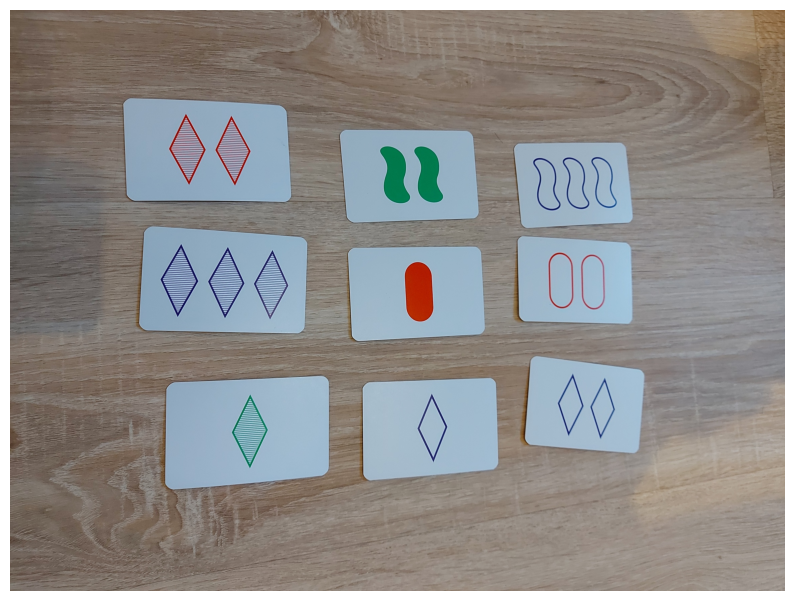

In [4]:
# Bild laden mit OpenCV
img = cv2.imread("set/set14.jpg")
imshow(img)

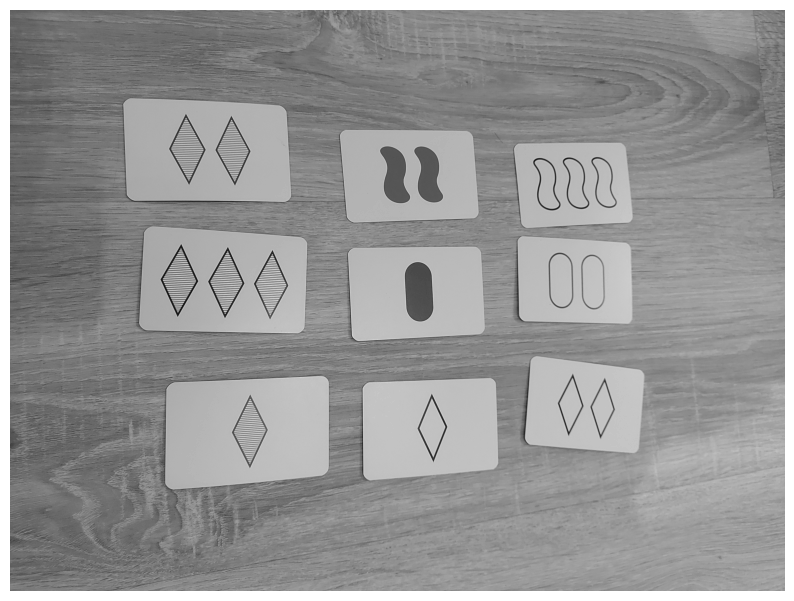

In [5]:
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

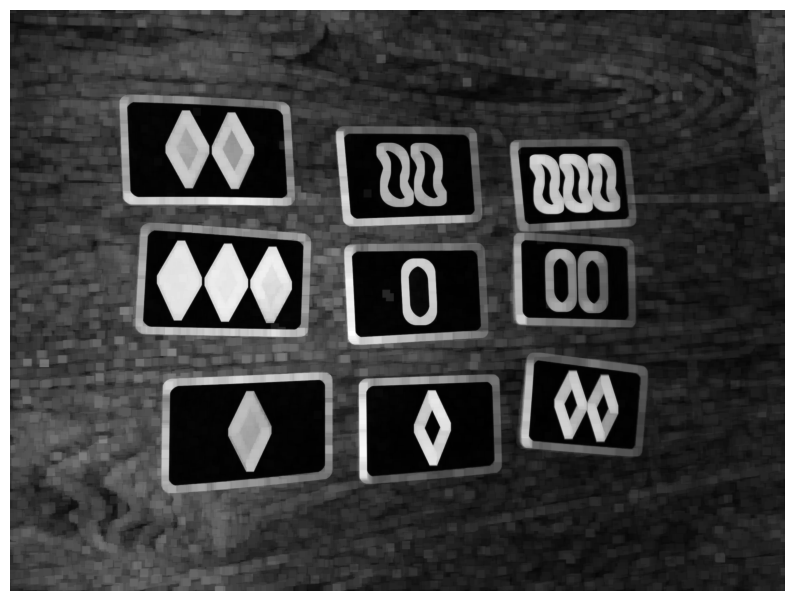

In [6]:
morphgradient=cv2.dilate(gray,np.ones((23,23)))-cv2.erode(gray,np.ones((23,23)))
imshow(morphgradient)

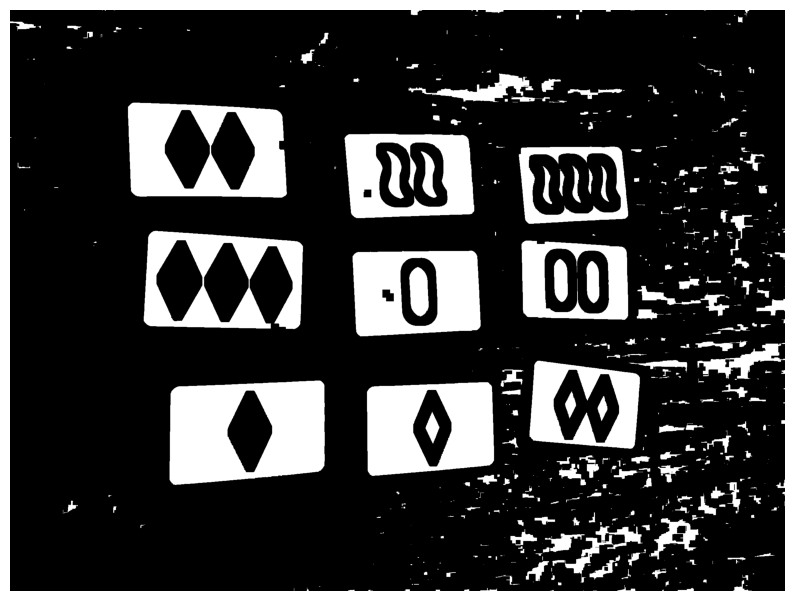

In [7]:
regions=(morphgradient<20).astype(np.uint8)
imshow(fullContrast(regions))

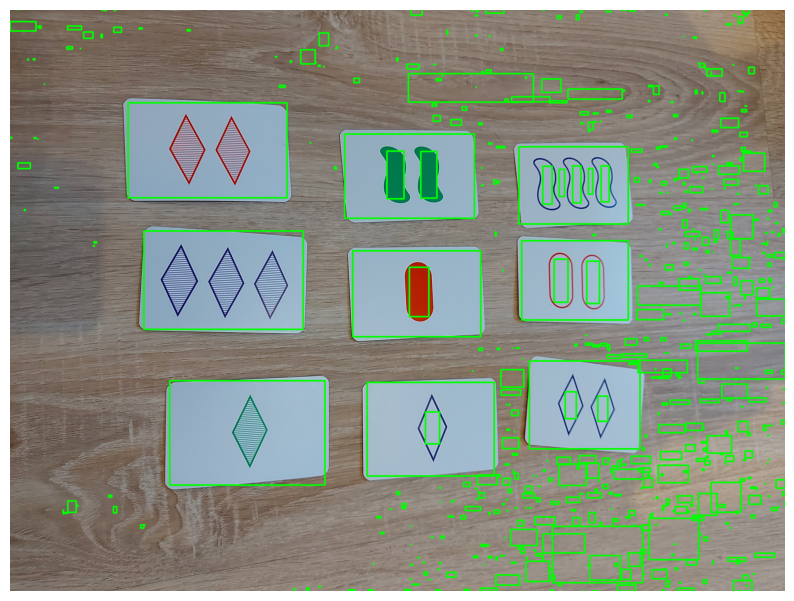

In [8]:
(numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(regions, 4, cv2.CV_32S)
boundingboxview=img.copy()
for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cv2.rectangle(boundingboxview,(x,y),(x+w,y+h),(0,255,0),3)
    mask=(labels==i).astype(np.uint8)
imshow(boundingboxview)

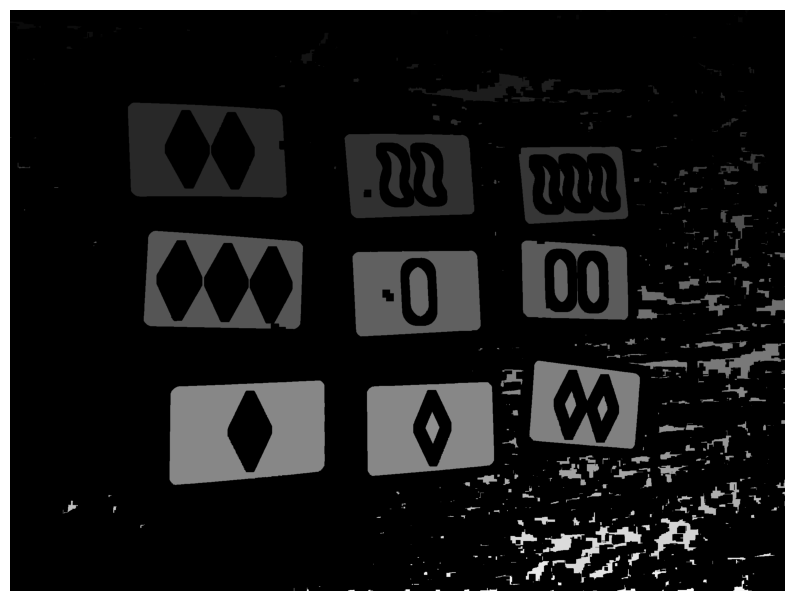

In [9]:
imshow(labels)

In [10]:
# Extrahieren aller äußeren Konturen als Liste von Pixelketten
contours,_ = cv2.findContours(regions,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))

598


In [11]:
contour=contours[62]
print(contour.shape)
print(contour)

(24, 1, 2)
[[[1427 1630]]

 [[1427 1631]]

 [[1427 1632]]

 [[1427 1633]]

 [[1427 1634]]

 [[1428 1634]]

 [[1429 1634]]

 [[1430 1634]]

 [[1431 1634]]

 [[1432 1634]]

 [[1433 1634]]

 [[1434 1634]]

 [[1435 1634]]

 [[1435 1633]]

 [[1435 1632]]

 [[1435 1631]]

 [[1435 1630]]

 [[1434 1630]]

 [[1433 1630]]

 [[1432 1630]]

 [[1431 1630]]

 [[1430 1630]]

 [[1429 1630]]

 [[1428 1630]]]


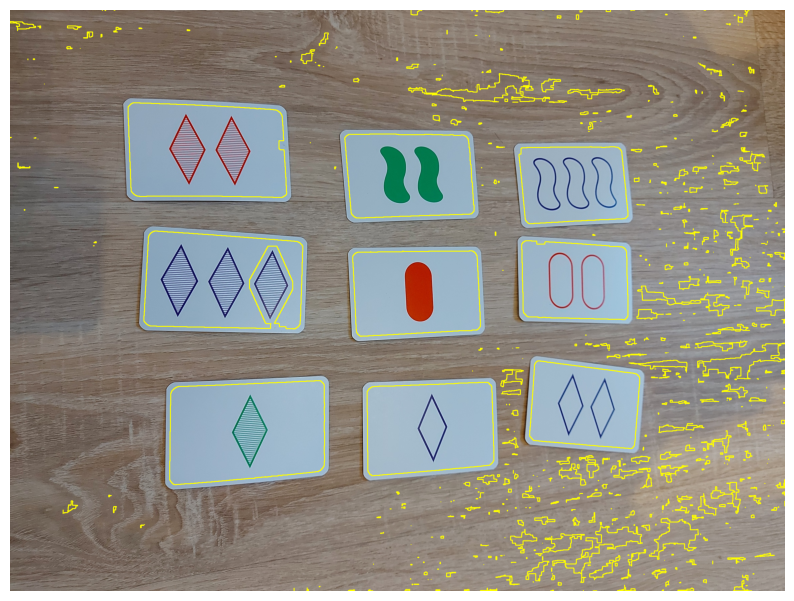

In [12]:
annotated=img.copy()

for contour in contours: 
    cv2.drawContours(annotated, [contour], 0, (0,255,255), 2)
    
imshow(annotated)

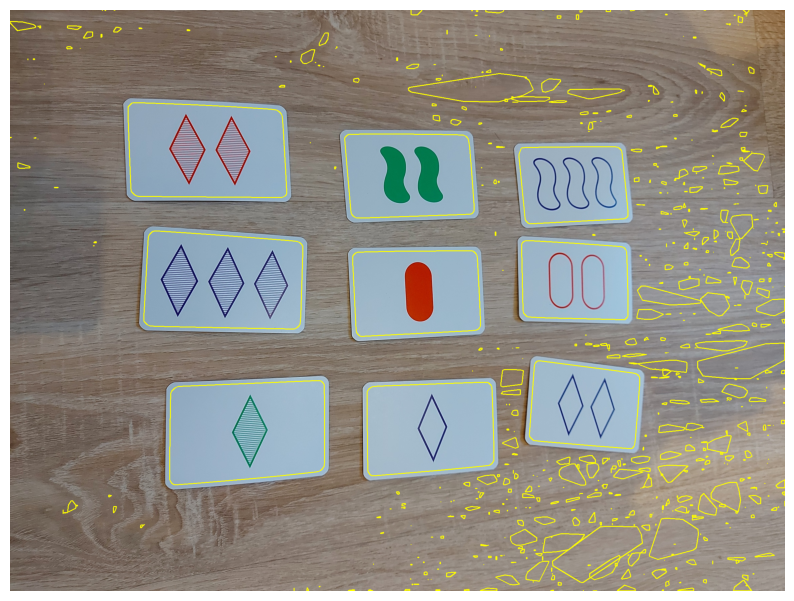

In [13]:
annotated=img.copy()

for contour in contours:
    
    convex=cv2.convexHull(contour) 

    cv2.drawContours(annotated, [convex], 0, (0,255,255), 2)

imshow(annotated)

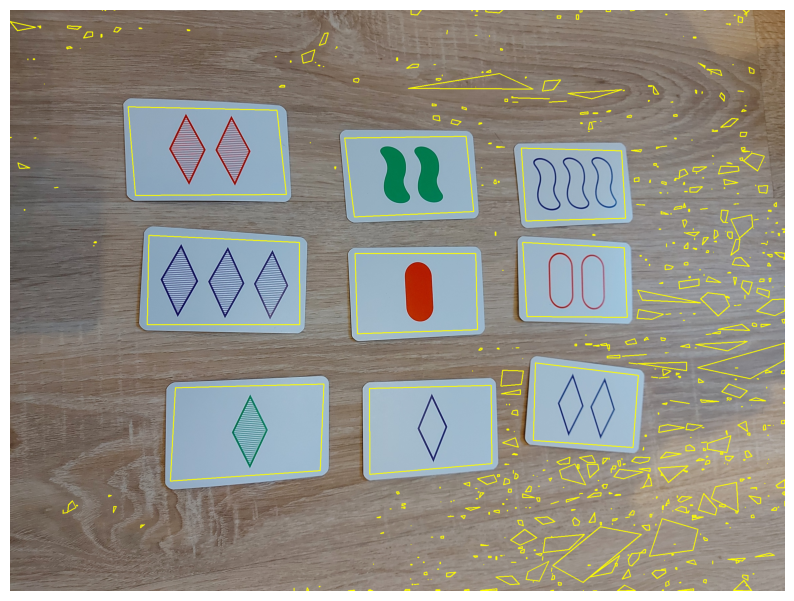

In [14]:
annotated=img.copy()

for contour in contours:
    convex=cv2.convexHull(contour) 

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    cv2.drawContours(annotated, [approx], 0, (0,255,255), 2)
imshow(annotated)

In [15]:
# Liste zum Speichern der Rechtecke zu den gefundenen Karten
card_quadrangles=[]


for contour in contours:

    convex=cv2.convexHull(contour) # Konvexe Hülle bilden

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    if(len(approx)!=4): # Viereckstest
        continue
        
    # Alle vier Kantenlängen ermitteln. "cv2.norm" berechnet per Default die L2-Norm, also den Euklidischen Abstand
    l0=cv2.norm(approx[0],approx[1]) 
    l1=cv2.norm(approx[1],approx[2])
    l2=cv2.norm(approx[2],approx[3])
    l3=cv2.norm(approx[3],approx[0])
    
    # Mittlere Breite und Höhe bestimmen (Annahme: Parallelogramm)
    w,h = (l0+l2)/2, (l1+l3)/2
    
    if(abs(l0-l2)>0.15*w) | (abs(l1-l3)>0.15*h): # Parallelogrammtest
        continue
    
    # Wenn Breite>Höhe: um 90° drehen (eine Karte ist höher als breit)
    if(w>h):
        w,h = h,w
        approx=np.roll(approx,1,axis=0)

    if(w  <100) | (h > 600): # Größentest
        continue

    if(h > 2.2*w) | (h<1.2 * w):   # Seitenverhältnistest
        continue

    card_quadrangles.append(np.squeeze(approx))

print(len(card_quadrangles))

9


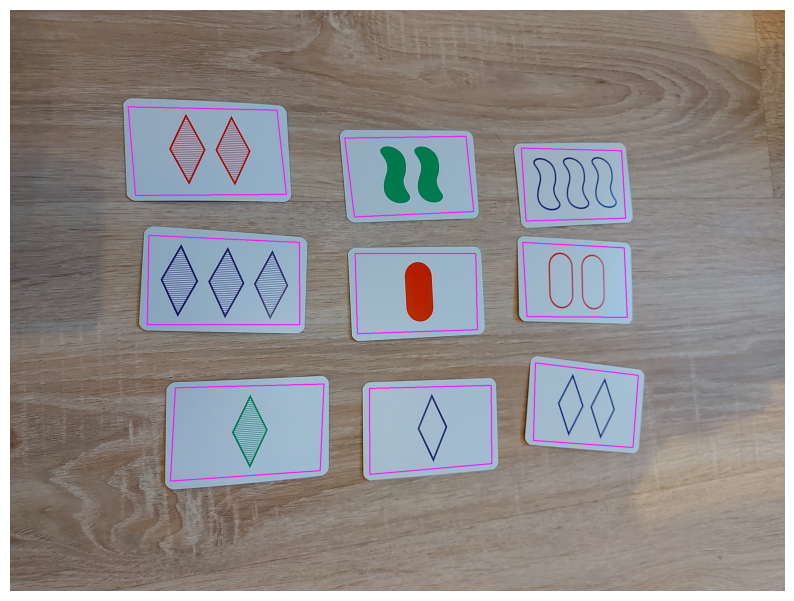

In [16]:
annotated=img.copy()
for quad in card_quadrangles:
    cv2.drawContours(annotated, [quad], 0, (255,0,255), 2)
imshow(annotated)

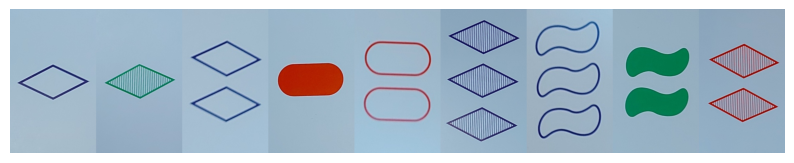

In [17]:
result = None

cards = []

for card in card_quadrangles:
    
    destRect = np.float32([[0,0],[300,0],[300,500],[0,500]])

    transformMatrix = cv2.getPerspectiveTransform(card.astype(np.float32), destRect)

    cardImage = cv2.warpPerspective(img,transformMatrix,(300,500))
    
    cards.append(cardImage)
    
    if result is None:
        result=cardImage.copy()
    else:
        result=np.concatenate([result,cardImage],axis=1)   

imshow(result)

In [31]:
for card in cards:
    gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
  
    # thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,2)
    # print(thresh)
    mask = cv2.inRange(gray, 0, 100)

    # Find the non-zero pixel coordinates in the mask
    points = cv2.findNonZero(mask)

    # Get the pixel values from the original image at the non-zero pixel coordinates
    values = np.array([card[x[0][1], x[0][0]] for x in points])

    
    # Print the pixel values
    # Create a blank 300x300 black image
    mycol = np.zeros_like(card)
    # Fill image with red color(set each pixel to red)
    mycol[:] = (values[0])
    combined = np.concatenate([card,mycol],axis=1) 
    # print(values[0])
    # print(val)
    # imshow(combined)
    

    x = np.array(values[0])
    color = np.argmax(x)  
    if(color == 0):
        print("blue")
    elif color == 1:
        print("green")
    elif color == 2:
        print("red")
    # print(x)

blue
blue
blue
red
red
blue
blue
green
red


In [18]:
#Anzahl
for card in cards:
    # Convert to grayscale
    gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)

    # Apply Otsu thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,2)

    # imshow(255 - thresh)
    
    objectCount = 0
    # Find contours
    contours, hierachy = cv2.findContours(255 - thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 13000:
            objectCount += 1
    
    print(objectCount)    


1
1
2
1
2
3
3
2
2


In [19]:
# Füllung detection
sampleStriped = cv2.imread('set/cards/card5_b_1_s_t.jpg',cv2.IMREAD_GRAYSCALE)
w, h = sampleStriped.shape[::-1]
sampleStriped = cv2.Canny(sampleStriped,10, 70)
template = sampleStriped[int(h/2 - 10):int(h/2 + 6), int(w/2 - 10):int(w/2 + 6)]

for card in cards:
    # Convert to grayscale
    gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray,(5,5),0)
    
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    #imshow(thresh)
    
    # Find contours
    contours, hierachy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)
        
        if area > 10000:
            # Get bounding rectangle of contour
            x, y, w, h = cv2.boundingRect(contour)
            
            # Extract ROI from original image
            roi = thresh[y:y+h,x:x+w]
            meanVal = np.mean(roi)

            roi_canny = blur[y:y+h,x:x+w]
            thresh_canny = cv2.Canny(roi_canny, 10, 70)
            meanCanny = np.mean(thresh_canny)
            
            result = cv2.matchTemplate(thresh_canny, template, cv2.TM_CCOEFF_NORMED)
            loc = np.where(result >= 0.5)
            
            # imshow(roi)
            # print(meanVal)

            # imshow(thresh_canny)
            # print(len(loc[0]))
            # print(meanCanny)

            if meanVal > 122:
                print("filled")
            else:
                if meanCanny > 20 or len(loc[0]) > 1:
                    print("striped")
                else: print("empty")
            break

empty
striped
empty
filled
empty
striped
empty
filled
striped


In [20]:
#TODO: Detect shape
for card in cards:
    gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray,(5,5),0)
    
    # thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,2)
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    contours, hierachy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 10000:
            # Get bounding rectangle of contour
            x, y, w, h = cv2.boundingRect(contour)
            
            approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
            #print(area)
            #print(len(approx))
            if len(approx) == 4:
                print("Viereck")
            if len(approx) == 10:
                print("Oval")
            if len(approx) > 10:
                print("Schlange")
            break

Viereck
Viereck
Viereck
Oval
Oval
Viereck
Schlange
Schlange
Viereck
